# Craigslist Capstone Project - Exploratory Data Analysis

#### The goal of this capstone is to predict market rent prices in the San Francisco Bay Area. The metros of interest are San Francisco, Peninsula, East Bay. 

Prior to this notebook, the data was parsed from html, cleaned and transformed. 

#### This notebook covers the scope of 

1. Explore The Data
2. Correlation between variables
3. Baseline price prediction
4. Drop unnecessary columns

## Importing the libraries

In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from scipy import stats
from sklearn.decomposition import PCA
from sklearn.preprocessing import scale
import warnings # For handling error messages. 
warnings.simplefilter(action="ignore", category=FutureWarning)
warnings.filterwarnings(action="ignore", module="scipy", message="^internal gelsd")
from pandas.core.common import SettingWithCopyWarning
warnings.simplefilter(action="ignore", category=SettingWithCopyWarning)

In [11]:
# Neighborhoods in SF
SFC_NEIGHBORHOODS = ['alamo square / nopa', 'bayview', 'bernal heights', 'castro / upper market', 'cole valley / ashbury hts', 'downtown / civic / van ness',
 'excelsior / outer mission', 'financial district', 'glen park', 'haight ashbury', 'hayes valley', 'ingleside / SFSU / CCSF', 'inner richmond',
 'inner sunset / UCSF', 'laurel hts / presidio', 'lower haight', 'lower nob hill', 'lower pac hts', 'marina / cow hollow', 'mission district',
 'nob hill', 'noe valley', 'north beach / telegraph hill', 'pacific heights', 'portola district', 'potrero hill', 'richmond / seacliff', 'russian hill', 
'SOMA / south beach', 'sunset / parkside', 'tenderloin','treasure island', 'twin peaks / diamond hts', 'USF / panhandle', 'visitacion valley', 
'west portal / forest hill', 'western addition']

# Neighborhoods in Peninsula
PEN_NEIGHBORHOODS = ['atherton','belmont','brisbane','burlingame','coastside/pescadero','daly city','east palo alto','foster city','half moon bay','los altos','menlo park','millbrae',
                     'mountain view','pacifica','palo alto','portola valley','redwood city','redwood shores','san bruno','san carlos','san mateo','south san francisco','woodside']

# Neighborhoods in the East Bay
EBY_NEIGHBORHOODS = ['alameda','albany / el cerrito','berkeley','berkeley north / hills','brentwood / oakley','concord / pleasant hill / martinez','danville / san ramon',
                     'dublin / pleasanton / livermore','emeryville','fairfield / vacaville','fremont / union city / newark','hayward / castro valley','hercules, pinole, san pablo, el sob',
                     'lafayette / orinda / moraga','oakland downtown','oakland east','oakland hills / mills','oakland lake merritt / grand','oakland north / temescal',
                     'oakland piedmont / montclair','oakland rockridge / claremont','oakland west','pittsburg / antioch','richmond / point / annex','san leandro','vallejo / benicia','walnut creek']
#List of cities
SFC_CITIES = ['San Francisco']
PEN_CITIES = ['Palo Alto','San Mateo','Mountain View','Redwood City','Menlo Park','Daly City','San Bruno','South San Francisco','Foster City','Burlingame']
EBY_CITIES = ['Oakland','Berkeley','Fremont','Walnut Creek','Concord','Hayward','Alameda','Pleasanton','San Leandro','Vallejo','San Ramon','Emeryville',
        'Dublin','Richmond','Fairfield','Livermore','Antioch','Pittsburg','Union City','El Cerrito']

ALL_CITIES = SFC_CITIES + PEN_CITIES + EBY_CITIES

# Dictionaries for neighborhood and city relationship
METRO_TO_NEIGHBORHOODS = {'sfc': SFC_NEIGHBORHOODS, 'pen': PEN_NEIGHBORHOODS, 'eby': EBY_NEIGHBORHOODS}
METRO_TO_CITIES = {'sfc': SFC_CITIES, 'pen': PEN_CITIES, 'eby': EBY_CITIES}

NEIGHBORHOOD_TO_METRO = {neighborhood: metro for metro, neighborhoods in METRO_TO_NEIGHBORHOODS.items() for neighborhood in neighborhoods}
CITY_TO_METRO = {city: metro for metro,cities in METRO_TO_CITIES.items() for city in cities}

# # Create a dictionary mapping listing_info values to the categorical column name
# LISTING_INFO_TO_COLUMN = {'cats are OK - purrr':'animals_cats','dogs are OK - wooof':'animals_dogs','furnished':'furnished',
#                     'no smoking':'smoking','wheelchair accessible':'wheelchair accessible','air conditioning':'has_AC',
#                      'EV charging':'hasEVCharging','laundry in bldg':'laundry_in_bldg','w/d in unit':'laundry_in_unit',
#                      'w/d hookups':'laundry_has_hookup','laundry on site':'laundry_onsite','no laundry on site':'laundry_not_onsite',
#                      'carport':'parking_carport','attached garage':'parking_attached_garage','detached garage':'parking_detached_garage',
#                      'off-street parking':'parking_offstreet','street parking':'parking_street','valet parking':'parking_valet','no parking':'parking_none',
#                      'rent period: daily':'rent_period_daily','rent period: weekly':'rent_period_weekly','rent period: monthly':'rent_period_monthly',
#                      'condo':'housing_condo','apartment':'housing_apt','cottage/cabin':'housing_cottage','duplex':'housing_duplex',
#                      'flat':'housing_flat','house':'housing_house','in-law':'housing_inlaw','loft':'housing_inlaw','townhouse':'housing_townhouse'}

# # Create a dictionary mapping listing_body features to the categorical column name
# LISTING_BODY_TO_COLUMN = {'rent control':'is_rent_controlled','no pets':'pets_allowed','remodelled':'is_remodelled',
#                          '(amenities)|(pool)|(gym)|(spa)':'has_amenities'}

## The Data:
We have the following variables for each unit/listing:

| Column name    | Datatype    | Description                                      |
|:---------------|:------------|:-------------------------------------------------|
|listing_nh|object|The neighborhood that the unit belongs to (see above for the full list)|
|listing_city|object|The city that the unit belongs to (see above for the full list)|
|listing_price|float|The unit's listed rental price|
|listing_sqft|float|The unit's area measured in square foot|
|listing_address|object|The physical address of the unit|
|animals_cats|boolean|Allows cats |
|animals_dogs|boolean|Allows dogs |
|smoking|boolean|Allows smoking|
|wheelchair accessible|boolean|Is wheelchair accessible|
|has_AC|boolean|Has Air Conditioning|
|hasEVCharging|boolean|Has Electric Charging for vehicles|
|laundry_in_bldg|boolean|The unit has laundry in the building but not inside the unit|
|laundry_in_unit|boolean|The unit has laundry in the unit|
|laundry_has_hookup|boolean|The unit has no laundry but can be installed|
|laundry_onsite|boolean|The unit has laundry onsite but outside the building|
|laundry_not_onsite|boolean|The unit does not have any laundry options|
|parking_carport|boolean|Has parking in a carport|
|parking_attached_garage|boolean|Has parking in an attached garage|
|parking_detached_garage|boolean|Has parking in a detached garage|
|parking_offstreet|boolean|Has parking offstreet e.g. driveway|
|parking_street|boolean|Has street parking|
|parking_valet|boolean|Has valet parking|
|parking_none|boolean|Has no parking options|
|rent_period_monthly|boolean|The unit is rented on a monthly basis|
|housing_condo|boolean|The unit is a condominium|
|housing_apt|boolean|The unit is an apartment|
|housing_flat|boolean|The unit is a flat|
|housing_house|boolean|The unit is a house|
|housing_townhouse|boolean|The unit is a townhouse|
|walk_score|float|A measure of the walkability of the unit's surroundings - measured from 0 to 100, the higher the better|
|transit_score|float|A measure of how good the transit options are near the unit - measured from 0 to 100, the higher the better|
|bike_score|float|A measure of the bikeability of the unit's surroundings - measured from 0 to 100, the higher the better|
|no_bedrooms|float|The number of bedrooms in the unit|
|no_bathrooms|float|The number of bathrooms in the unit|
|is_rent_controlled|boolean|Is the unit rent controlled by local rental laws|
|pets_allowed|boolean|Does the unit allow pets - this could be animals other than cats or dogs|
|has_amenities|boolean|Does the unit have amenities (pool, gym, spa) for use|
|premium_finishes|boolean|Does the unit have any premium finishes: granite, marble, walnut, millwork, a fireplace, built-in cabinetry|
|ensuite_bath|boolean|Does the unit have an ensuite bathroom|
|has_balcony|boolean|Does the unit have balconies|
|has_backyard|boolean|Does the unit have a backyard|
|has_view|boolean|Does the unit have views/or is a penthouse|
|multi-level|boolean|Is the unit a multi-level 3, 4 or 5 story house|
|is_an_SRO|boolean|Is the unit an SRO. An SRO is a single room occupancy, generally room only, with access to shared bathroom and kitchen|



## Load the data

In [12]:
# The cleaned html listing data is the interim directory
dir_folder = '/Users/pandabear/springboard/CapstoneTwoProject/data/interim/'
df = pd.read_csv(dir_folder + 'listing_df_cleaned.csv',index_col='listing_id')

In [13]:
df.head()

,listing_title,listing_nh,listing_city,listing_date,listing_price,listing_bedrooms,listing_bathrooms,listing_sqft,listing_address,listing_info,...,pets_allowed,is_remodelled,has_amenities,premium_finishes,ensuite_bath,has_balcony,has_backyard,has_view,multi-level,is_an_SRO
listing_id,,,,,,,,,,,,,,,,,,,,,
7520103440,Beautiful and Spacious NEW remodeled Silicon V...,fremont / union city / newark,Fremont,2022-08-11 09:51:58-07:00,3800,3,2,1495.0,Newport Dr,open house dates saturday 2022-08-13 sun...,...,0,0,1,1,0,0,1,0,0,0
7520905091,Highly desired Vista neighborhood with a charm...,vallejo / benicia,Vallejo,2022-08-13 09:04:22-07:00,2100,2,1,904.0,226 Edgemont Avenue near Edgemont Avenue,EV charging air conditioning cats are OK - ...,...,0,0,1,0,0,0,1,0,0,0
7520907681,lovely 2-bedroom 2 bath home with open floor p...,vallejo / benicia,Vallejo,2022-08-13 09:09:26-07:00,2200,2,2,1420.0,1509 Sacramento Street near Sacramento Street,EV charging air conditioning cats are OK - ...,...,0,0,1,0,0,0,1,0,0,0
7520608095,"$3,935 / 2br - 1266ft2 - NEW LOW RATE! Spaciou...",dublin / pleasanton / livermore,Pleasanton,2022-08-12 12:34:49-07:00,3935,2,2,1266.0,1552 E Gate Way,air conditioning application fee details: $5...,...,0,0,1,1,0,0,0,1,0,0
7520200206,Great Fully Furnished Studio-Livermore-Pet fri...,dublin / pleasanton / livermore,Livermore,2022-08-11 13:02:24-07:00,3000,0,2,NaN,2380 Nissen Drive,air conditioning cats are OK - purrr dogs a...,...,0,0,1,0,0,0,0,0,0,0


In [14]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 12396 entries, 7520103440 to 7532425139
Data columns (total 60 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   listing_title            12396 non-null  object 
 1   listing_nh               12396 non-null  object 
 2   listing_city             12396 non-null  object 
 3   listing_date             12396 non-null  object 
 4   listing_price            12396 non-null  int64  
 5   listing_bedrooms         12396 non-null  object 
 6   listing_bathrooms        12396 non-null  object 
 7   listing_sqft             8498 non-null   float64
 8   listing_address          12079 non-null  object 
 9   listing_info             12396 non-null  object 
 10  listing_body             12396 non-null  object 
 11  listing_url              12396 non-null  object 
 12  listing_first_image      12396 non-null  object 
 13  listing_info_split       12396 non-null  object 
 14  animals_

## 1. Explore The Data

Text(0, 0.5, 'City')

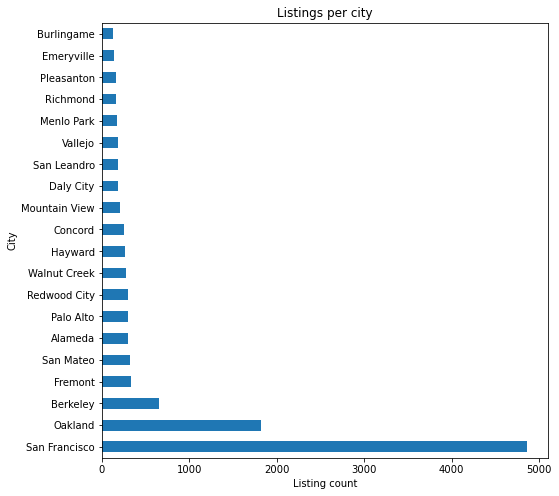

In [15]:
# Plot the distribution of listings per city
df['listing_city'].value_counts().head(20).plot(kind='barh',figsize=(8,8))
plt.title("Listings per city")
plt.xlabel("Listing count")
plt.ylabel("City")

In [16]:
df['listing_city'].value_counts().tail(20)

Mountain View          212
Daly City              189
San Leandro            184
Vallejo                183
Menlo Park             174
Richmond               164
Pleasanton             158
Emeryville             143
Burlingame             126
El Cerrito             123
San Bruno              122
San Ramon              121
Dublin                 118
South San Francisco    117
Livermore              115
Antioch                111
Foster City             97
Fairfield               96
Pittsburg               80
Union City              74
Name: listing_city, dtype: int64

In [17]:
# Count frequency of listings by neighborhood and city
nh_count = df[['listing_nh','listing_city']].value_counts().reset_index()
nh_count.columns = ['neighborhood', 'city', 'count']
nh_metro_df = pd.DataFrame(nh_count)
nh_metro_df['metro'] = nh_metro_df.apply(lambda x: CITY_TO_METRO[x.city], axis=1)
nh_metro_df.head()

,neighborhood,city,count,metro
0,berkeley,Berkeley,554,eby
1,SOMA / south beach,San Francisco,513,sfc
2,oakland lake merritt / grand,Oakland,504,eby
3,mission district,San Francisco,391,sfc
4,nob hill,San Francisco,342,sfc


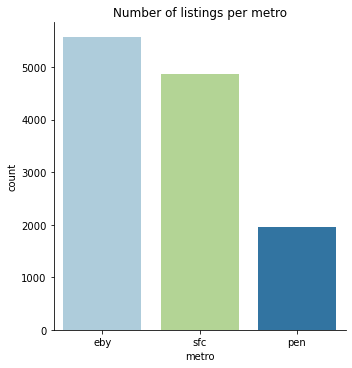

In [18]:
metro_total = pd.DataFrame(nh_metro_df.groupby(['metro'])['count'].sum()).reset_index()
metro_total
sns.catplot(data=metro_total, x="metro", y="count", hue='metro', kind='bar', dodge=False, order=['eby','sfc','pen'], palette=sns.color_palette('Paired')).set(title="Number of listings per metro")


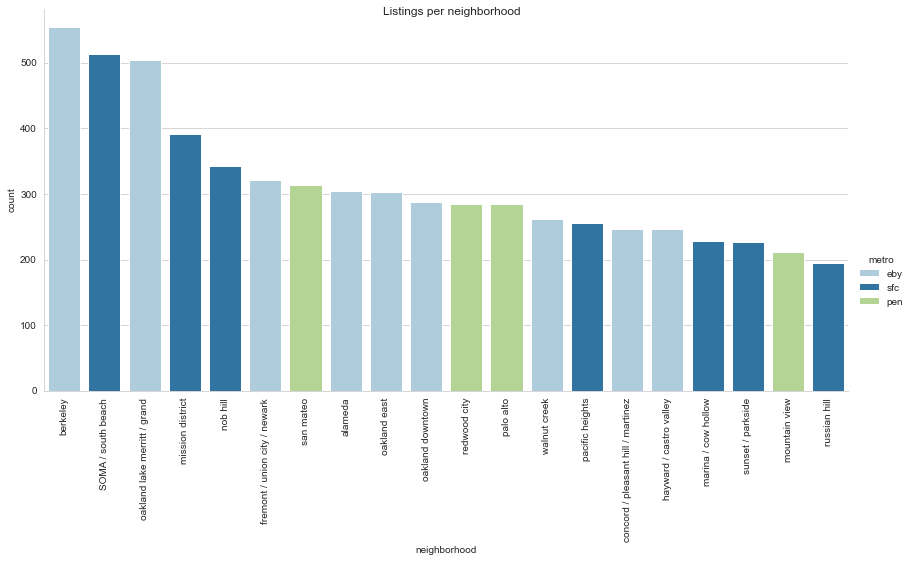

In [19]:
sns.set_style(style="whitegrid")
g = sns.catplot(x='neighborhood', y='count', data = nh_metro_df[:20], hue='metro', kind='bar',height=6, aspect=2, dodge=False, palette=sns.color_palette('Paired'))
g.fig.suptitle("Listings per neighborhood")
g.set_xticklabels(rotation=90)

There seems to be an equal spread of listings across the metros. 


In [20]:
nh_metro_df.shape
#.metro.value_counts()

(168, 4)

In [21]:
sorted_prices_by_city = df.groupby('listing_city').listing_price.mean().sort_values().reset_index()
sorted_city_list = sorted_prices_by_city['listing_city']
sorted_prices_by_city

,listing_city,listing_price
0,Vallejo,2238.606557
1,Richmond,2507.542683
2,Concord,2527.664000
3,Pittsburg,2533.562500
4,Fairfield,2542.885417
5,Antioch,2566.324324
6,San Leandro,2601.228261
7,Hayward,2625.632184
8,Oakland,2714.443225
9,El Cerrito,2808.065041


Text(0.5, 1.0, 'Listing City vs Listing Price (sorted by mean price per city)')

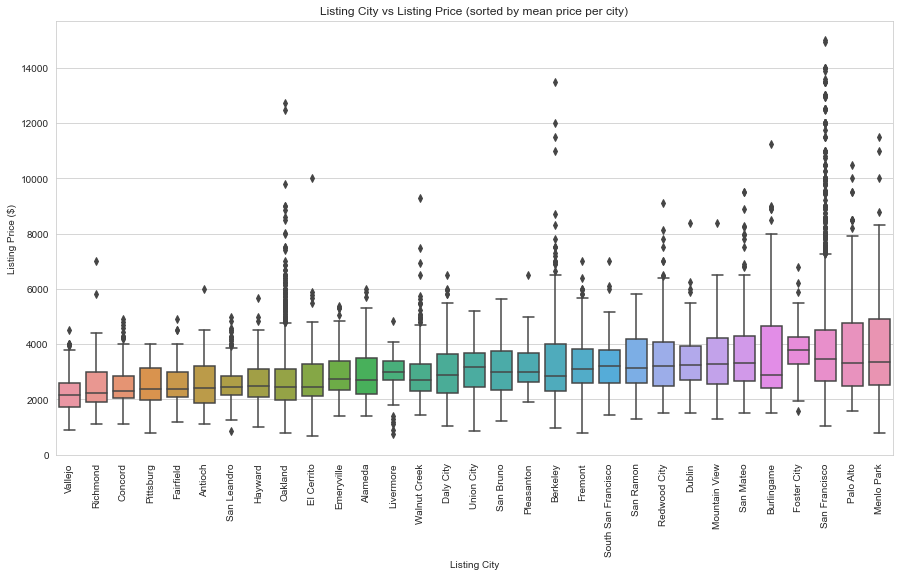

In [22]:
# Boxplot of the distribution of prices for each city
plt.subplots(figsize=(15, 8))
sns.boxplot(x='listing_city', y='listing_price', data=df, order = sorted_city_list)
plt.xticks(rotation='vertical')
plt.ylabel('Listing Price ($)')
plt.xlabel('Listing City')
plt.title('Listing City vs Listing Price (sorted by mean price per city)')

[(500.0, 15000.0)]

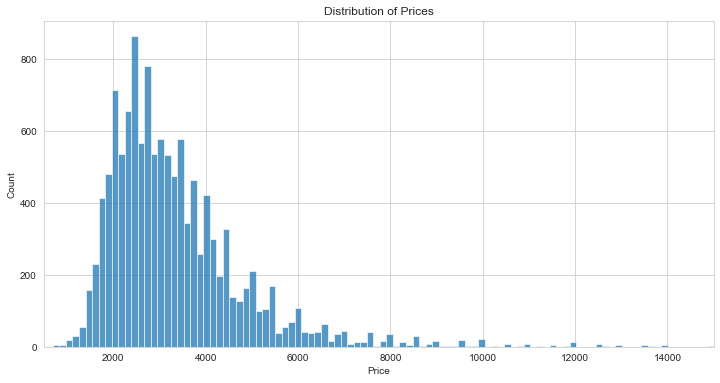

In [23]:
# Look at the distribution of price
plt.figure(figsize=(12, 6))
g = sns.histplot(data=df['listing_price'], palette=sns.color_palette('crest'))
plt.title("Distribution of Prices")
plt.xlabel("Price")
plt.ylabel('Count')
g.set(xlim=(500,15000))

In [24]:
# # The distribution of prices looks normally distributed with a very long right tail. To correct for this tail, remove rows that are more than 3 standard deviations away from the mean. 
# upper_limit_listing_price = df['listing_price'].mean() + df['listing_price'].std() * 3
# print(f'Upper limit of listing price: ${upper_limit_listing_price:.0f}')

# num_right_tail = len(df[df['listing_price'] > upper_limit_listing_price])
# print(f'Removing {num_right_tail} rows from the dataframe, or {num_right_tail/len(df):.2f}%')

# # Drop rows that are more than 3 standard deviations away from the mean listing_price
# df = df[(df['listing_price'] < upper_limit_listing_price)]

In [25]:
# # Plot the distribution again to check the distribution looks more normally distributed
# plt.figure(figsize=(12, 6))
# g = sns.histplot(data=df['listing_price'], palette=sns.color_palette('crest'))
# plt.title("Distribution of Prices")
# plt.xlabel("Price")
# plt.ylabel('Count')
# g.set(xlim=(500,upper_limit_listing_price))

Text(58.873681262253754, 2200, 'mean: 75')

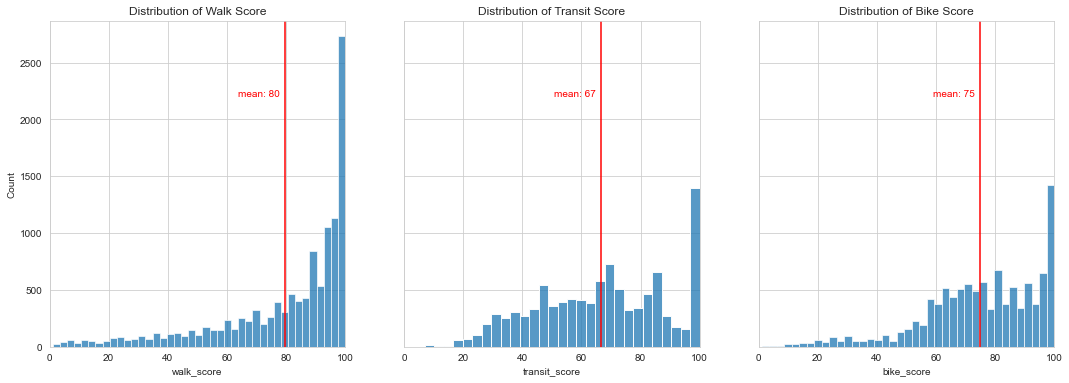

In [26]:
# Look at the distribution of walk, transit and bike scores per neighborhood
fig, (ax1, ax2, ax3) = plt.subplots(ncols=3, sharey=True, figsize=(18,6))
g1 = sns.histplot(data=df['walk_score'], ax=ax1)
g2 = sns.histplot(data=df['transit_score'], ax=ax2)
g3 = sns.histplot(data=df['bike_score'], ax=ax3)
g1.axvline(df['walk_score'].mean(), color='red')
g2.axvline(df['transit_score'].mean(), color='red')
g3.axvline(df['bike_score'].mean(), color='red')
ax1.set_xlim(0, 100)
ax2.set_xlim(0, 100)
ax3.set_xlim(0, 100)
ax1.set_title("Distribution of Walk Score")
ax2.set_title("Distribution of Transit Score")
ax3.set_title("Distribution of Bike Score")
ax1.text(x = df['walk_score'].mean()-16, y=2200, s = 'mean: {:.0f}'.format(df['walk_score'].mean()), color = 'red')
ax2.text(x = df['transit_score'].mean()-16, y=2200, s = 'mean: {:.0f}'.format(df['transit_score'].mean()), color = 'red')
ax3.text(x = df['bike_score'].mean()-16, y=2200, s = 'mean: {:.0f}'.format(df['bike_score'].mean()), color = 'red')

It looks like there are many places with walk scores close to 100. This makes sense as a lot of the neighborhoods are very urban. 

In [69]:
# What percentage of listings allow cats? dogs? all pets?
animals_percent = pd.DataFrame()
animals_percent['cats_allowed'] = df['animals_cats'].value_counts(normalize=True)
animals_percent['dogs_allowed'] = df['animals_dogs'].value_counts(normalize=True)
animals_percent['pets_allowed'] = df['pets_allowed'].value_counts(normalize=True)
animals_percent

,cats_allowed,dogs_allowed,pets_allowed
0,0.565586,0.626008,0.799532
1,0.434414,0.373992,0.200468


[(0.0, 1.0)]

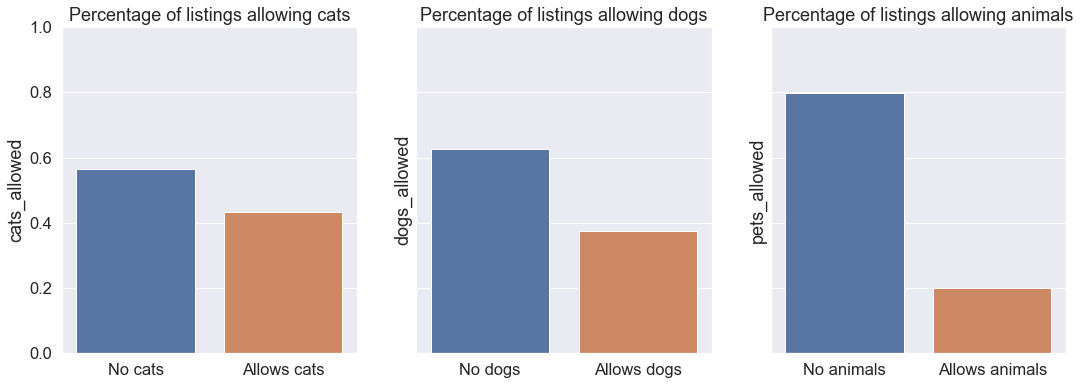

In [116]:
fig, (ax1, ax2, ax3) = plt.subplots(ncols=3, sharey=True, figsize=(18,6))
g1 = sns.barplot(data=animals_percent, x=animals_percent.index, y='cats_allowed', ax=ax1)
g2 = sns.barplot(data=animals_percent, x=animals_percent.index, y='dogs_allowed', ax=ax2)
g3 = sns.barplot(data=animals_percent, x=animals_percent.index, y='pets_allowed', ax=ax3)
ax1.set_title("Percentage of listings allowing cats")
ax2.set_title("Percentage of listings allowing dogs")
ax3.set_title("Percentage of listings allowing animals")
ax1.set_xticks([0,1],labels=['No cats', 'Allows cats'])
ax2.set_xticks([0,1],labels=['No dogs', 'Allows dogs'])
ax3.set_xticks([0,1],labels=['No animals', 'Allows animals'])
ax1.set(ylim=(0, 1))

Surprisingly, only 43% of listings allow cats. More places allow cats than dogs, and only 20% of properties allow all animals (such as birds, reptiles, farm animals)

## 2. Correlation between variables

In [27]:
df.head()

,listing_title,listing_nh,listing_city,listing_date,listing_price,listing_bedrooms,listing_bathrooms,listing_sqft,listing_address,listing_info,...,pets_allowed,is_remodelled,has_amenities,premium_finishes,ensuite_bath,has_balcony,has_backyard,has_view,multi-level,is_an_SRO
listing_id,,,,,,,,,,,,,,,,,,,,,
7520103440,Beautiful and Spacious NEW remodeled Silicon V...,fremont / union city / newark,Fremont,2022-08-11 09:51:58-07:00,3800,3,2,1495.0,Newport Dr,open house dates saturday 2022-08-13 sun...,...,0,0,1,1,0,0,1,0,0,0
7520905091,Highly desired Vista neighborhood with a charm...,vallejo / benicia,Vallejo,2022-08-13 09:04:22-07:00,2100,2,1,904.0,226 Edgemont Avenue near Edgemont Avenue,EV charging air conditioning cats are OK - ...,...,0,0,1,0,0,0,1,0,0,0
7520907681,lovely 2-bedroom 2 bath home with open floor p...,vallejo / benicia,Vallejo,2022-08-13 09:09:26-07:00,2200,2,2,1420.0,1509 Sacramento Street near Sacramento Street,EV charging air conditioning cats are OK - ...,...,0,0,1,0,0,0,1,0,0,0
7520608095,"$3,935 / 2br - 1266ft2 - NEW LOW RATE! Spaciou...",dublin / pleasanton / livermore,Pleasanton,2022-08-12 12:34:49-07:00,3935,2,2,1266.0,1552 E Gate Way,air conditioning application fee details: $5...,...,0,0,1,1,0,0,0,1,0,0
7520200206,Great Fully Furnished Studio-Livermore-Pet fri...,dublin / pleasanton / livermore,Livermore,2022-08-11 13:02:24-07:00,3000,0,2,NaN,2380 Nissen Drive,air conditioning cats are OK - purrr dogs a...,...,0,0,1,0,0,0,0,0,0,0


In [28]:
# Look at the correlation between variables
df.corr()

,listing_price,listing_sqft,animals_cats,animals_dogs,furnished,smoking,wheelchair accessible,has_AC,hasEVCharging,laundry_in_bldg,...,pets_allowed,is_remodelled,has_amenities,premium_finishes,ensuite_bath,has_balcony,has_backyard,has_view,multi-level,is_an_SRO
listing_price,1.000000,0.707761,0.043633,0.116032,0.053710,0.029915,0.048551,0.069108,0.110450,-0.148217,...,-0.091545,0.000642,0.114004,0.144175,0.210762,-0.019138,0.174467,0.134375,0.040477,-0.003776
listing_sqft,0.707761,1.000000,-0.085517,-0.033917,-0.009561,-0.003891,-0.079546,0.118396,0.016968,-0.185740,...,-0.002851,-0.003382,0.039721,0.179881,0.156276,-0.067004,0.291819,0.027678,0.034060,-0.000212
animals_cats,0.043633,-0.085517,1.000000,0.821058,0.030396,0.183037,0.270487,0.157367,0.216577,0.020679,...,-0.422581,-0.003255,0.088841,-0.013570,-0.003179,0.111260,-0.061759,0.058086,0.008411,0.014709
animals_dogs,0.116032,-0.033917,0.821058,1.000000,0.062010,0.179675,0.304831,0.203192,0.245698,-0.055017,...,-0.375787,-0.004440,0.116153,-0.012160,0.019349,0.123031,-0.037974,0.057054,0.006795,0.022261
furnished,0.053710,-0.009561,0.030396,0.062010,1.000000,0.038707,0.105547,0.144005,0.131820,0.001059,...,-0.047282,0.014741,-0.018503,-0.026000,0.005158,0.002037,0.007255,0.005416,0.007864,0.005358
smoking,0.029915,-0.003891,0.183037,0.179675,0.038707,1.000000,0.158707,0.185093,0.126014,0.083127,...,0.096726,-0.007263,0.039095,0.016125,0.014014,0.009124,-0.020089,0.025185,0.026334,0.015705
wheelchair accessible,0.048551,-0.079546,0.270487,0.304831,0.105547,0.158707,1.000000,0.325763,0.418034,-0.059226,...,-0.126728,-0.009841,0.131179,-0.014776,-0.008177,0.155043,-0.064702,0.063051,-0.003581,0.033029
has_AC,0.069108,0.118396,0.157367,0.203192,0.144005,0.185093,0.325763,1.000000,0.324577,-0.131908,...,-0.062561,-0.005814,0.094168,0.066820,0.002546,0.106219,0.035792,0.022070,-0.009280,-0.006900
hasEVCharging,0.110450,0.016968,0.216577,0.245698,0.131820,0.126014,0.418034,0.324577,1.000000,-0.080132,...,-0.095873,0.010252,0.112239,0.013015,0.027039,0.113611,-0.022509,0.077615,0.001395,-0.005182
laundry_in_bldg,-0.148217,-0.185740,0.020679,-0.055017,0.001059,0.083127,-0.059226,-0.131908,-0.080132,1.000000,...,0.078443,-0.010333,-0.039218,-0.044589,-0.032853,-0.044224,-0.074647,0.007272,0.005442,-0.008481


Text(0.5, 1.0, 'Heatmap of craigslist features')

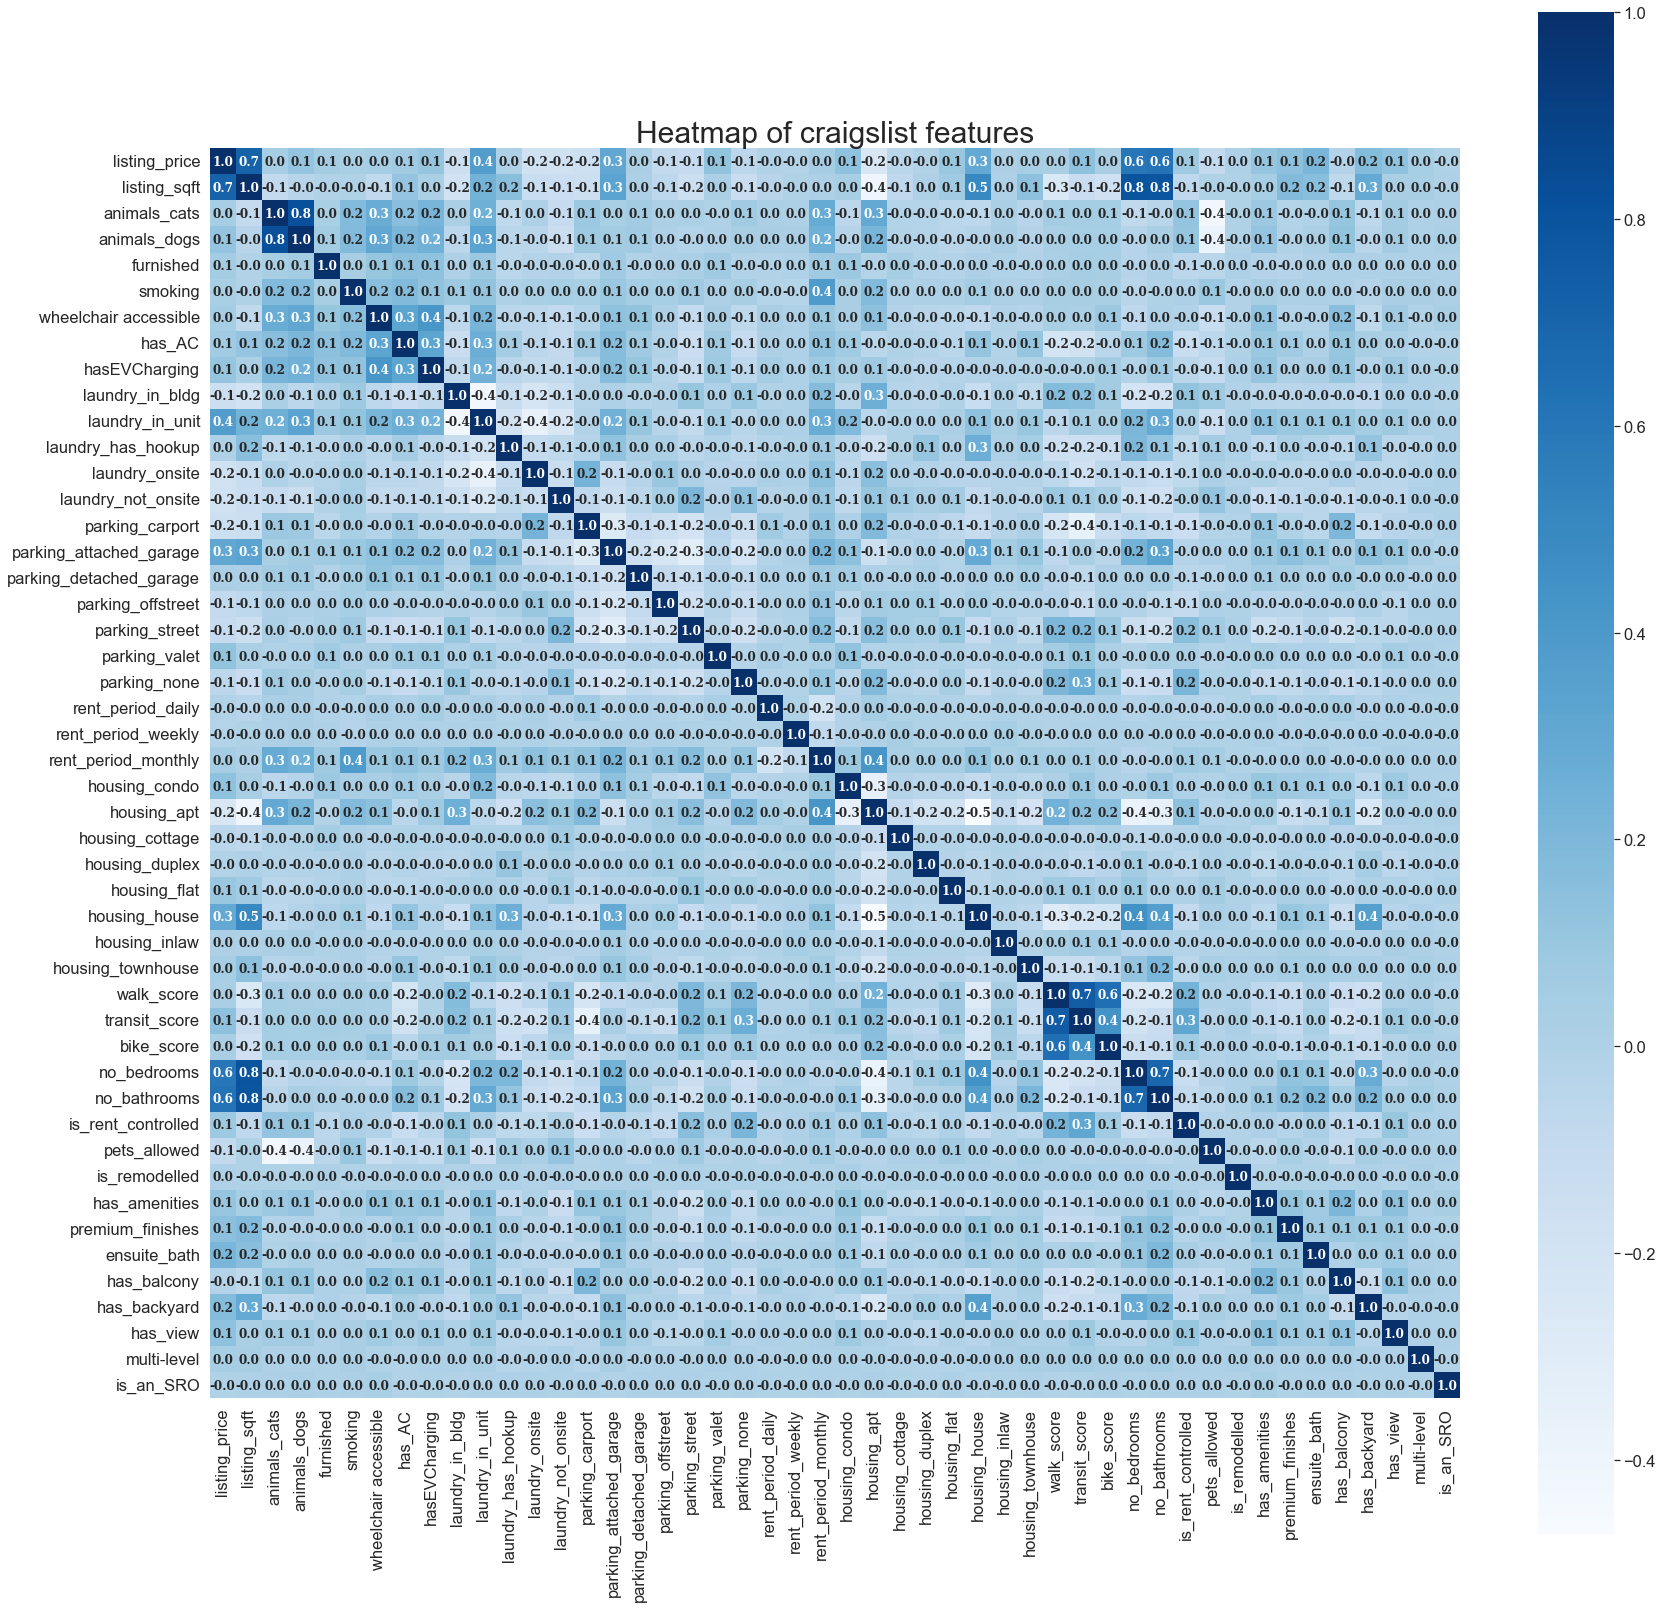

In [29]:
#Make a heatmap of the data 
plt.figure(figsize=(28, 28))
sns.set(font_scale=1.5)
sns.heatmap(df.corr(), cmap='Blues',
            annot=True,
            fmt=".1f",
            annot_kws={
                'fontsize': 12,
                'fontweight': 'bold',
                'fontfamily': 'serif'
            },square=True)
plt.title('Heatmap of craigslist features', fontsize = 30) 


Numeric features that seem most correlated with price are:
* Listing_sqft
* Number of bedrooms
* Number of bathrooms
* Laundry in unit
* Parking in an attached garage
* A house, apartment or condo
* Allows cats or dogs
* Valet parking
* Has EV charging

Other features that are noteworthy: 
* Walk score, transit score and bike score are highly correlated
* Number of bedrooms and bathrooms is correlated to square footage
* Allowing cats and dogs
* Rental type house and listing sqft

Features that can be dropped because they don't seem to have any correlation:
* rent_period_daily
* rent_period_weekly
* housing_cottage
* housing_duplex
* housing_inlaw
* is_remodelled
* furnished

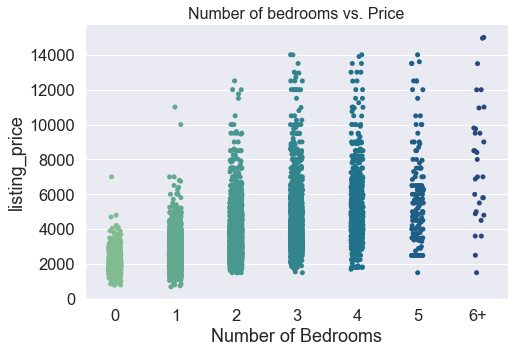

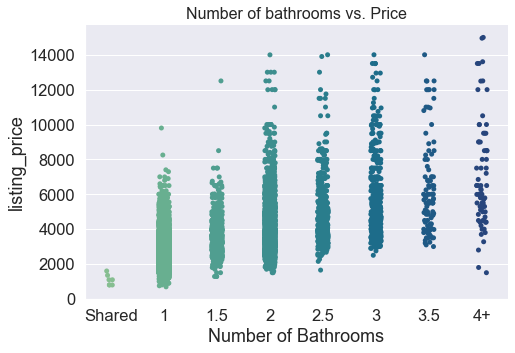

In [30]:
# Plot bedrooms/bathrooms against price
a = sns.catplot(x='no_bedrooms', y="listing_price", data=df, palette="crest", height=5, aspect=1.5)
plt.title("Number of bedrooms vs. Price", fontsize=16)
a.set_xticklabels(['0','1','2','3','4','5','6+'])
a.set_xlabels('Number of Bedrooms')
b = sns.catplot(x='no_bathrooms', y="listing_price", data=df, palette="crest", height=5, aspect=1.5)
plt.title("Number of bathrooms vs. Price", fontsize=16)
b.set_xticklabels(['Shared','1','1.5','2','2.5','3','3.5','4+'])
b.set_xlabels('Number of Bathrooms')

The plots make sense, as we would expect price to increase with the number of bedrooms/bathrooms. Shared bathroom rentals i.e. SROs seems to be an obvious low price category with few outliers.

In [31]:
df.head()

,listing_title,listing_nh,listing_city,listing_date,listing_price,listing_bedrooms,listing_bathrooms,listing_sqft,listing_address,listing_info,...,pets_allowed,is_remodelled,has_amenities,premium_finishes,ensuite_bath,has_balcony,has_backyard,has_view,multi-level,is_an_SRO
listing_id,,,,,,,,,,,,,,,,,,,,,
7520103440,Beautiful and Spacious NEW remodeled Silicon V...,fremont / union city / newark,Fremont,2022-08-11 09:51:58-07:00,3800,3,2,1495.0,Newport Dr,open house dates saturday 2022-08-13 sun...,...,0,0,1,1,0,0,1,0,0,0
7520905091,Highly desired Vista neighborhood with a charm...,vallejo / benicia,Vallejo,2022-08-13 09:04:22-07:00,2100,2,1,904.0,226 Edgemont Avenue near Edgemont Avenue,EV charging air conditioning cats are OK - ...,...,0,0,1,0,0,0,1,0,0,0
7520907681,lovely 2-bedroom 2 bath home with open floor p...,vallejo / benicia,Vallejo,2022-08-13 09:09:26-07:00,2200,2,2,1420.0,1509 Sacramento Street near Sacramento Street,EV charging air conditioning cats are OK - ...,...,0,0,1,0,0,0,1,0,0,0
7520608095,"$3,935 / 2br - 1266ft2 - NEW LOW RATE! Spaciou...",dublin / pleasanton / livermore,Pleasanton,2022-08-12 12:34:49-07:00,3935,2,2,1266.0,1552 E Gate Way,air conditioning application fee details: $5...,...,0,0,1,1,0,0,0,1,0,0
7520200206,Great Fully Furnished Studio-Livermore-Pet fri...,dublin / pleasanton / livermore,Livermore,2022-08-11 13:02:24-07:00,3000,0,2,NaN,2380 Nissen Drive,air conditioning cats are OK - purrr dogs a...,...,0,0,1,0,0,0,0,0,0,0


Text(0.5, 1.0, 'Number of bedrooms vs. listing square footage')

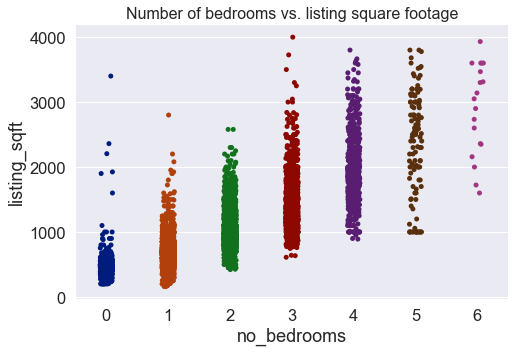

In [32]:
# Plot distribution of listing_sqft by number of bedrooms
sns.catplot(x='no_bedrooms', y="listing_sqft", data=df, palette="dark", height=5, aspect=1.5)
plt.title("Number of bedrooms vs. listing square footage", fontsize=16)

It is clear there are some outliers that are most likely data entered incorrectly, i.e. 20000 instead of 2000. In the proprocessing stage, remove the outliers that are more than 3 standard deviations away, grouped by number of bedrooms 

(100.0, 20000.0)

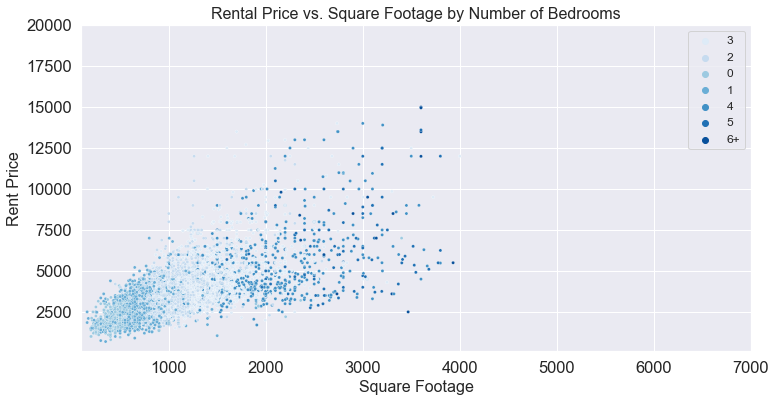

In [33]:
# Plot scatterplot showing distribution of price and sqft
plt.figure(figsize=(12, 6))
sns.scatterplot(y='listing_price', x='listing_sqft', hue='listing_bedrooms', palette='Blues', data=df, s=10)
plt.legend(fontsize=12)
plt.xlabel("Square Footage", fontsize=16)
plt.ylabel("Rent Price", fontsize=16);
plt.title("Rental Price vs. Square Footage by Number of Bedrooms", fontsize=16)
plt.xlim([100, 7000])
plt.ylim([100, 20000])
# x_jitter=True, y_jitter=True, s=125,

## 3. Baseline price prediction

A very basic baseline for price prediction would be the mean price for the number of bedrooms and bathrooms a listing has.
This kind of statistic is often quoted in news articles about rental prices. 
Group by bedroom,bathroom and plot the price distribution

In [34]:
# Find the mean listing_price for number of bedrooms and bathrooms
mean_price_bedroom = df.groupby(['listing_bedrooms','listing_bathrooms']).mean()['listing_price'].reset_index()
mean_price_bedroom

,listing_bedrooms,listing_bathrooms,listing_price
0,0,1,2117.245628
1,0,1.5,2478.500000
2,0,2,4084.000000
3,0,shared,1075.714286
4,1,1,2563.401251
5,1,1.5,3471.559633
6,1,2,3775.241935
7,1,2.5,4786.250000
8,2,1,3073.700767
9,2,1.5,3347.072917


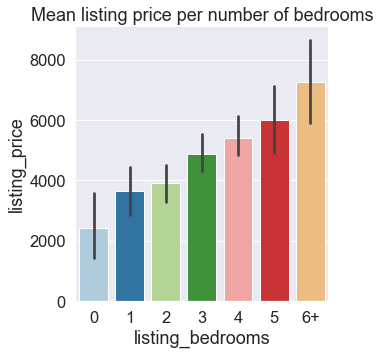

In [35]:
sns.catplot(data=mean_price_bedroom, x="listing_bedrooms", y="listing_price", kind='bar',dodge=False, order=['0','1','2','3','4','5','6+'], palette=sns.color_palette('Paired')).set(title="Mean listing price per number of bedrooms")

There seems to be a much larger variation in price for studios, ranging from 2000 to 7000. The confidence interval is wider, probably because there are outliers dragging up the mean. It also doesn't make sense that studios would be more expensive than one bedroom listings. Try plotting the distribution of 0 bedroom listings against bathrooms:

In [36]:
studio_price = df[df['no_bedrooms'] == 0][['no_bathrooms','listing_price']]
studio_price

,no_bathrooms,listing_price
listing_id,,
7520200206,2.0,3000
7520974161,1.0,2922
7518811098,1.0,1895
7519693551,1.0,2095
7522295883,1.0,2295
...,...,...
7542622674,1.0,3193
7543599179,1.0,2100
7535129494,1.0,2324


Text(0, 0.5, 'Count')

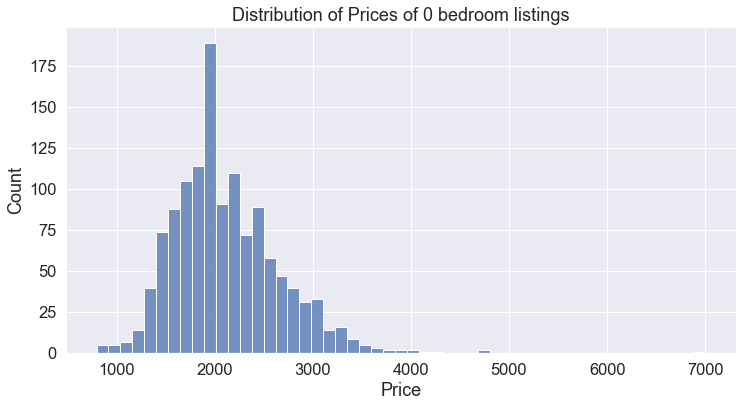

In [37]:
# Look at the distribution of price for 0 bedroom listings
plt.figure(figsize=(12, 6))
g = sns.histplot(data=studio_price['listing_price'], palette=sns.color_palette('Paired'))
plt.title("Distribution of Prices of 0 bedroom listings")
plt.xlabel("Price")
plt.ylabel('Count')

The distribution has a very long tail. I suspect users are defaulting to 0 bedrooms if they forget to change the drop down box in craigslist. This distribution will need outliers removed

## 4. Drop unnecessary columns

In [38]:
# Drop unused categorical features
# Also drop columns that seem to have no effect on price
cat_features = ['listing_title','listing_date','listing_bedrooms','listing_bathrooms','listing_info',
                'listing_body','listing_url','listing_first_image','listing_info_split','rent_period_daily',
                'rent_period_weekly', 'housing_cottage','housing_duplex','housing_inlaw','is_remodelled',
                'furnished']
df.drop(cat_features,axis=1,inplace=True)

In [39]:
df.shape

(12396, 44)

In [40]:
print(f'There are {len(df.listing_city.value_counts())} cities and {len(df.listing_nh.value_counts())} neighborhoods in this dataset')

There are 31 cities and 82 neighborhoods in this dataset


In [41]:
# df.loc[7507524793]

The remaining categorical features neighborhood and city will be imputed with mean price data in the preprocessing portion of this project. 

In [42]:
df.to_csv(r'/Users/pandabear/springboard/CapstoneTwoProject/data/interim/listing_df_EDA.csv', header=True)
print('Saved to csv file')

Saved to csv file
